In [12]:
import pandas as pd
import seaborn as sns
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute, roll_time_series
import numpy as np
import matplotlib.pyplot as plt

# Original Data Loading and Preparation
flights = sns.load_dataset('flights')
month_map = {
    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
    'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
}
flights['month_str'] = flights['month'].map(month_map).astype(str)
flights['year_str'] = flights['year'].astype(str)
flights['date'] = flights['year_str'] + '-' + flights['month_str'] + '-01'
flights['date'] = pd.to_datetime(flights['date'])

# Data prep for tsfresh rolling process
flights_prepared = flights[['date', 'passengers']].copy()
flights_prepared['id'] = 1
flights_prepared = flights_prepared.rename(columns={'date': 'time', 'passengers': 'value'})

# Add a lagged column (t-1), which excludes the current time point (t)
flights_prepared['value_lag1'] = flights_prepared['value'].shift(1)


# Creating windows

In [13]:

window_length = 12

# Create Windowed Data using roll_time_series
print(f"Creating rolling windows with length {window_length} using roll_time_series...")

rolled_flights_df = roll_time_series(
    flights_prepared,
    column_id='id',
    column_sort='time',
    max_timeshift=window_length,
)

print("Rolling windows created.")


c:\Users\douglas.sgrott_indic\miniconda3\envs\tsfresh_venv\lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(


Creating rolling windows with length 12 using roll_time_series...


Rolling: 100%|██████████| 36/36 [00:08<00:00,  4.08it/s]

Rolling windows created.


# Feature extraction

In [18]:

# Define Features to Extract
fc_parameters = {
    "length": None,
    # "large_standard_deviation": [{"r": 0.05}, {"r": 0.1}],
    "mean": None,
    "median": None,
    "standard_deviation": None,
    "variance": None,
    "maximum": None,
    "minimum": None,
    "abs_energy": None
}

# Extract Features on the Rolled Data
print("\nExtracting features from windows...")
extracted_features_windows = extract_features(
    rolled_flights_df,
    default_fc_parameters=fc_parameters,
    column_id='id',        # Use the new window IDs created by roll_time_series
    column_sort='time',    # Time column within each window
    column_value='value',  # Specify the value column for feature calculation
    disable_progressbar=False
)

# Impute missing values
impute(extracted_features_windows)
print(f"\nNumber of windows processed: {len(extracted_features_windows)}")



Extracting features from windows...


Feature Extraction: 100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Number of windows processed: 144


# Merging the data back together

In [ ]:
if extracted_features_windows.index.nlevels > 1:
    extracted_features_windows = extracted_features_windows.reset_index(names=["id", "time"])

feature_store = pd.merge(flights_prepared, extracted_features_windows, how="left", on=["time", "id"])
feature_store

,time,value,id,value_lag1,value__length,value__mean,value__median,value__standard_deviation,value__variance,value__maximum,value__minimum,value__abs_energy
0,1949-01-01,112,1,NaN,1.0,112.000000,112.0,0.000000,0.000000,112.0,112.0,12544.0
1,1949-02-01,118,1,112.0,2.0,115.000000,115.0,3.000000,9.000000,118.0,112.0,26468.0
2,1949-03-01,132,1,118.0,3.0,120.666667,118.0,8.379870,70.222222,132.0,112.0,43892.0
3,1949-04-01,129,1,132.0,4.0,122.750000,123.5,8.104783,65.687500,132.0,112.0,60533.0
4,1949-05-01,121,1,129.0,5.0,122.400000,121.0,7.282857,53.040000,132.0,112.0,75174.0
...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08-01,606,1,622.0,13.0,470.692308,461.0,81.042614,6567.905325,622.0,362.0,2965549.0
140,1960-09-01,508,1,606.0,13.0,466.769231,461.0,77.844178,6059.715976,622.0,362.0,2911132.0
141,1960-10-01,461,1,508.0,13.0,466.615385,461.0,77.853451,6061.159763,622.0,362.0,2909284.0
142,1960-11-01,390,1,461.0,13.0,465.307692,461.0,78.978463,6237.597633,622.0,362.0,2895735.0


# Plotting

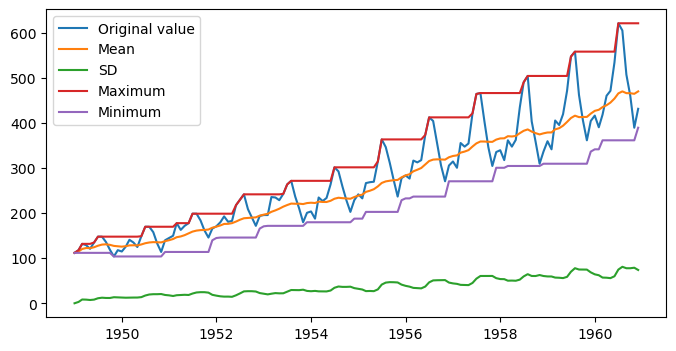

In [28]:
fig, axes = plt.subplots(figsize=(8,4))

axes.plot(feature_store['time'], feature_store['value'], label="Original value")
axes.plot(feature_store['time'], feature_store['value__mean'], label="Mean")
axes.plot(feature_store['time'], feature_store['value__standard_deviation'], label="SD")
# axes.plot(feature_store['time'], feature_store['value__variance'], label="Variance")
axes.plot(feature_store['time'], feature_store['value__maximum'], label="Maximum")
axes.plot(feature_store['time'], feature_store['value__minimum'], label="Minimum")
# axes.plot(feature_store['time'], feature_store['value__abs_energy'], label="Abs. Energy")

plt.legend()